* Name: `dissipation-theory--Study-15.ipynb`
* Author: John A. Marohn
* Date: 2023-12-28
* Continued from: `dissipation-theory--Study-11.ipynb`
* Continued to: ---
* Summary: Calculate dissipation versus height over a sample with properties similar to Rachael's PM6:Y6 and compare to Marohn's analytical expression derived in the thick-sample limit.  This notebook recalculates the successful fit in `dissipation-theory--Study-11.ipynb` and further explores the result.

# Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dissipationtheory.constants import ureg, qe, epsilon0, kb
from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation import theta1norm_jit, gamma_perpendicular_jit, gamma_perpendicular_approx

In [3]:
from dissipationtheory.constants import epsilon0
from dissipationtheory.capacitance import Csphere

In [4]:
THIS = 'dissipation-theory--Study-15'

# Friction versus charge density

Compute the friction $\gamma_{\perp}$ versus charge density $\rho$ using Lekkala's Model I, with the substrate dielectric constant set to $10^6$ to mimic a metal substrate.  Create variables for all the importants parameters, with units:

In [5]:
hs = ureg.Quantity(110, 'nanometer')   # measured
epsilons = complex(3.4, 0.)            # reasonable guess
rho = ureg.Quantity(1e24,'m^{-3}')     # wild guess
mu = ureg.Quantity(1e-4, 'cm^2/(s V)') # representative number

fc = ureg.Quantity(75, 'kHz')       # measured
Vts = ureg.Quantity(1, 'volt')      # measured
r = ureg.Quantity(30, 'nanometer')  # spec
h = ureg.Quantity(120, 'nanometer') # measured

Use the fast, `jit` version of the Sample and Cantilever model.  The `jit` version expects unitless parameters.

In [6]:
sample1_jit = SampleModel1Jit(
    cantilever=CantileverModelJit(
        fc.to('Hz').magnitude, 
        Vts.to('V').magnitude,  
        r.to('m').magnitude, 
        h.to('m').magnitude), 
    epsilon_s=epsilons,
    h_s=hs.to('m').magnitude,
    mu=mu.to('m^2/(s V)').magnitude,
    rho=rho.to('m^{-3}').magnitude,
    epsilon_d=complex(1.0e6, 0.),
    z_r=h.to('m').magnitude)

Create an array of charge densities to loop over.  Compute the associated conductivity $\sigma$.

In [7]:
rho_= ureg.Quantity(np.logspace(start=17, stop=27, num=50), '1/m^3')
sigma_ = (qe * mu * rho_).to('1/(ohm m)')

The `SampleModel1Jit` object computes the Debye length internally.  Capture it inside the loop.

In [8]:
%%time
result1 = {
    'rho': rho_,
    'sigma': sigma_,
    'gamma': ureg.Quantity(np.zeros_like(rho_), 'pN s/m'),
    'L_Debye': ureg.Quantity(np.zeros_like(rho_), 'm')
}

for index, rho__ in enumerate(rho_):

        sample1_jit.rho = rho__.to('1/m^3').magnitude
        result1['L_Debye'][index] = ureg.Quantity(sample1_jit.LD, 'm')
        result1['gamma'][index] = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')

CPU times: user 408 ms, sys: 6.43 ms, total: 414 ms
Wall time: 420 ms


Plot the friction versus charge density, with the Debye length as a second $x$ axis. See the advice [here](https://stackoverflow.com/questions/10514315/how-to-add-a-second-x-axis) and [here](https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/secondary_axis.html) describing how to add a second $x$ axis to a `matplotlib` figure. 

For plotting, we need to define a function to convert from charge density (the first $x$ axis) to Debye length (the second $x$ axis) and vice versa.  We can use the numbers computed by the `SampleModel1Jit` object as a sanity check for these functions.  Print out the Debye length at the initial charge density.

In [9]:
(result1['rho'][[0]], result1['L_Debye'][[0]])

(array([1.e+17]) <Unit('1 / meter ** 3')>,
 array([3.77977755e-06]) <Unit('meter')>)

Define a stand-alone function that converts between charge density and Debye length.  The function works on the $x$ axis in the plot, so should have unitless inputs and outputs.

In [10]:
def forward(rho):
    rho = ureg.Quantity(rho, '1/m^3')
    T = ureg.Quantity(300, 'K')
    LD = np.sqrt((epsilon0 * kb * T)/(rho * qe * qe))
    return LD.to('m').magnitude

Verify that the forward function works as expected.

In [11]:
forward(1.0e17)

3.7797775481848926e-06

Now define a reverse function that converts from Debye length to charge density.  The function should again have unitless inputs and outputs.

In [12]:
def reverse(LD):
    LD = ureg.Quantity(LD, 'm')
    T = ureg.Quantity(300, 'K')
    rho = (epsilon0 * kb * T)/(LD * LD * qe * qe)
    return rho.to('1/m^3').magnitude

Verify that the reverse function works as expected.

In [13]:
reverse(3.77977755e-06)

9.999999990395694e+16

Now are are ready to create the plot.  To avoid a user warning, as recommended [here](https://stackoverflow.com/questions/37309559/using-matplotlib-giving-me-the-following-warning-userwarning-tight-layout), use `fig.set_tight_layout(True)` instead of `plt.tight_layout()`.  The following code produces a "divide by zero" run-time warning coming from the `forward` and `reverse` functions.  I assume this warning is generated by some internal `matplotlib` function calls.  Don't worry about it.

/Users/jam99/Library/Caches/pypoetry/virtualenvs/dissipationtheory-Uvi85QQO-py3.8/lib/python3.8/site-packages/pint/facets/plain/quantity.py:1119: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/Users/jam99/Library/Caches/pypoetry/virtualenvs/dissipationtheory-Uvi85QQO-py3.8/lib/python3.8/site-packages/pint/facets/plain/quantity.py:1119: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


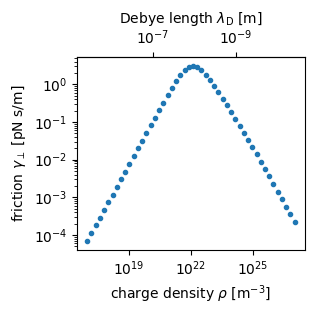

In [14]:
fig, ax = plt.subplots(figsize=(3.25, 3.25), constrained_layout=True)
ax.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '.')
ax.set_xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
ax.set_ylabel('friction $\gamma_{\perp}$ [pN s/m]')

ax2 = ax.secondary_xaxis('top', functions=(forward, reverse))
ax2.set_xlabel('Debye length $\lambda_{\mathrm{D}}$ [m]')

fig.set_tight_layout(True)

plt.savefig(THIS + '--Fig-1.png', dpi=300)
plt.savefig(THIS + '--Fig-1.pdf')
plt.show()

# Fit to empirical model inspired by Dwyer

In [15]:
from dissipationtheory.capacitance import Csphere

What capacitance formula should we use to compute the tip charge? At low charge density, the Debye screening length is larger than the sample thickness.  In this limit, it is appropriate to model the tip as a sphere over a metal-backed dielectric.  At high charge density, the Debye length is much smaller than the sample thickness.  In this limit, it is more appropriate to moodel the tip as a sphere over a metal.

Over most of the sample density range in the above plot, the Debye length is less than the sample thickness of 100 nm.  To compute the tip-sample capacitance, and derivatives, let us therefore approximate the sample as a metal.


Use the function `Csphere` to compute the capacitance. The function `Cphere` expects an *array* of heights.  In the code below, create an array of sample heights `h_` that is just one element long.  

In [18]:
h_ = ureg.Quantity(np.array([h.to('m').magnitude]), 'm') 
c0 = Csphere(0, height=h_, radius=r, nterm=21)
c1 = Csphere(1, height=h_, radius=r, nterm=21)

Create an empirical fit function.  Modify this function slightly from `func4` in `Study-11`: (1) The capacitance is not computed by treating the tip as a sphere over a metal and (2) The capacitance is $C = 4 \pi \epsilon_0 k_C$, which is larger by a factor of $4 \pi$ than the one in `func4`.  The resulting $k_C$ should now be a factor of $4 \pi$ smaller.  The reason for including the factor of $4 \pi$ in the capacitance definition is that it facilities comparison of the empirical capacitance $C$ to the tip-sample capacitance at infinite separation, $4 \pi \epsilon_0 r$, with $r$ the tip radius.

In [50]:
def func(rho_unitless, kR_unitless, kC_unitless): 
    
    rho = ureg.Quantity(rho_unitless, '1/m^3')
    kR = ureg.Quantity(kR_unitless, 'm')
    kC = ureg.Quantity(kC_unitless, 'm')
    omega = 2 * np.pi * fc
    sigma = qe * mu * rho
    gamma = (c1**2 * Vts**2 * sigma * kR)/(sigma**2 * kR**2 + omega**2 * (4 * np.pi * epsilon0 * kC)**2)
    
    return gamma.to('pN s/m').magnitude

Use the package `lmfit` to carry out a least-squares fit of the simulated friction to the empirical function `func`.

In [51]:
from lmfit import Model, Parameters

When performing the least-squares fitting,

* restrict $k_R$ and $k_C$ to be positive;
* fit with proportional error bars, or else the fit will be assuming uniform error bars and weight the largest data the most; and 
* pick the error bars, arbitrarily, to be 1 percent of the data.

The error bars are arbitrary, but it is important that they are *proportional* to the data.

In [52]:
xfit = result1['rho'].to('1/m^3').magnitude
yfit = result1['gamma'].to('pN s/m').magnitude
yerr = 0.01 * yfit

In [53]:
model = Model(func)

pars = Parameters() 
pars.add('kR_unitless', value=1e-8, min=0)
pars.add('kC_unitless', value=1e-8, min=0)

result = model.fit(yfit, rho_unitless=xfit, params=pars, weights=1/yerr)

In [54]:
result

In [55]:
def plotfit(xfit, yfit, ycalc, yerr, figname):

    fig, axs = plt.subplots(
        figsize=(3.25,4.00),
        nrows=2,
        sharex=True, gridspec_kw={'height_ratios': [1, 3]})
    
    dy = 100 * (yfit - ycalc)/yfit
    opts = dict(marker='o', mfc='w', ms=4, capsize=3, linestyle='none')
    
    axs[0].errorbar(xfit, dy, yerr=yerr, **opts, color='tab:blue')
    axs[0].set_ylabel('resid. [%]')
    
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].errorbar(xfit, yfit, yerr=yerr, **opts, color='tab:blue')
    axs[1].plot(xfit, ycalc, 'k-')

    ax2 = axs[0].secondary_xaxis('top', functions=(forward, reverse))
    ax2.set_xlabel('Debye length $\lambda_{\mathrm{D}}$ [m]')
    
    plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
    plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
    
    fig.align_ylabels()
    plt.tight_layout()
    
    plt.savefig(THIS + '--' + figname, dpi=300)
    plt.savefig(THIS + '--' + figname + '.pdf')
    
    plt.show()

/Users/jam99/Library/Caches/pypoetry/virtualenvs/dissipationtheory-Uvi85QQO-py3.8/lib/python3.8/site-packages/pint/facets/plain/quantity.py:1119: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


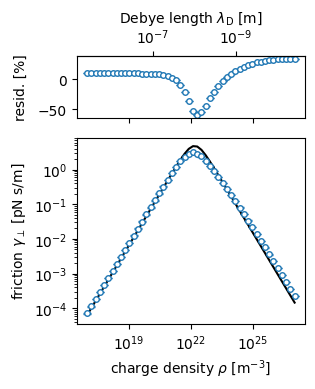

In [56]:
ycalc =  result.best_fit
plotfit(xfit, yfit, ycalc, yerr, 'Fig-2')

Save the best-fit values of $k_C$ and $k_R$ as variables with units.

In [57]:
kCopt = ureg.Quantity(result.best_values['kC_unitless'],'m')
kRopt = ureg.Quantity(result.best_values['kR_unitless'],'m')

Print out the best-fit parameters.

In [64]:
print("kR = {:0.2f} nm".format(kRopt.to('nm').magnitude))
print("kC = {:0.2f} nm".format(kCopt.to('nm').magnitude))
print(" r = {:0.2f} nm".format(r.to('nm').magnitude))

kR = 32.68 nm
kC = 15.11 nm
 r = 30.00 nm


# Discussion

Compare the 
* tip capacitance at $h = \infty$, $C_{\infty} = 4 \pi \epsilon_0 r$, with $r$ the tip radius; 
* tip capacitance at the given height $h$ over a metallic substrate, $c_0$; and 
* the empirically-determined capacitance $C = \epsilon_0 \, k_C$ obtained from the above fit.  

In [72]:
C = 4 * np.pi * epsilon0 * kCopt
cinf = 4 * np.pi * epsilon0 * r

print("  tip-sample capacitance at infinity: cinf = {:0.2f} aF".format(Cinf.to('aF').magnitude))
print("     tip-sample capacitance over metal: c0 = {:0.2f} aF".format(c0[0].to('aF').magnitude))
print("            empirical total capacitance: C = {:0.2f} aF".format(C.to('aF').magnitude))

  tip-sample capacitance at infinity: cinf = 3.34 aF
     tip-sample capacitance over metal: c0 = 3.71 aF
            empirical total capacitance: C = 1.68 aF


The empirically-determined capacitance $C$ is *less that* the tip capacitance $c_0$.  This finding is at odds with the Dwyer treatment, which predicts that $C = c_0 + C_{\mathrm{s}}$ with $c_0$ the tip capacitance and $C_{\mathrm{s}}$ the sample capacitance, requiring that $C > c_0$.